## Prep

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import numpy as np
import os

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

logging.basicConfig(format=
                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
#                     filename="/tmp/caiman.log",
                    level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [18]:
caiman_data_path = 'C:/Users/ll357/Documents/CaImAn/demos/temp_data/'
tif_files = glob.glob(caiman_data_path + 'i1369_220311/' + "*.tif", recursive = True)
print(tif_files)

# fnames = tif_files[0]
fnames = tif_files[-1]
fnames

['C:/Users/ll357/Documents/CaImAn/demos/temp_data/i1369_220311\\i1369_220311_002_multipage.tif', 'C:/Users/ll357/Documents/CaImAn/demos/temp_data/i1369_220311\\i1369_220311_003_multipage.tif']


'C:/Users/ll357/Documents/CaImAn/demos/temp_data/i1369_220311\\i1369_220311_003_multipage.tif'

In [19]:
param_area = 'LM'
param_ca = 'gcamp6s'
# param_stim = 'grating'
param_stim = 'bunnytop high res slow'

fr = 30                             # imaging rate in frames per second
decay_time = 0.8                    # length of a typical transient in seconds
# revised to account for gcamp6s, ~750 ms decay time in V1 L2/3: https://elifesciences.org/articles/51675
# decay_time: Length of a typical transient in seconds. decay_time is an approximation of the time scale over which to expect a significant shift in the calcium signal during a transient. It defaults to 0.4, which is appropriate for fast indicators (GCaMP6f), slow indicators might use 1 or even more. However, decay_time does not have to precisely fit the data, approximations are enough.
# V1 layer 2/3: rise and decay time constants for GCaMP6f are 50-100 ms and 200-300 ms; and for GCaMP6s 150-200 ms and ~750 ms (4-5 APs, Figure 3C). https://elifesciences.org/articles/51675

# motion correction parameters
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = True             # flag for performing non-rigid motion correction

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thr = 0.85            # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 2                       # number of components per patch
gSig = [8, 8]               # expected half size of neurons in pixels
# gSig kept 4 according to snipaste pixel measurement 
# -> changed to 6 to match with mag 2.8x, and changed K from 4 to 2. 2022-03-08
# -> changed to 8 since gSig=6 was still segmented too small. 8 looks good.
# adjust cell size bc of zoom change around 2021-09

method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
ssub = 1                    # spatial subsampling during initialization
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 2.0               # signal to noise ratio for accepting a component
rval_thr = 0.90             # space correlation threshold for accepting a component # adjusted
rval_lowest = 0.0           # added to eliminate fake overlapping neurons, default -1
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.50           # neurons with cnn probability lower than this value are rejected # adjusted


opts_dict = {'fnames': fnames,
            'fr': fr,
            'decay_time': decay_time,
            'strides': strides,
            'overlaps': overlaps,
            'max_shifts': max_shifts,
            'max_deviation_rigid': max_deviation_rigid,
            'pw_rigid': pw_rigid,
            'p': p,
            'nb': gnb,
            'rf': rf,
            'K': K, 
            'stride': stride_cnmf,
            'method_init': method_init,
            'rolling_sum': True,
            'only_init': True,
            'ssub': ssub,
            'tsub': tsub,
            'merge_thr': merge_thr, 
            'min_SNR': min_SNR,
            'rval_thr': rval_thr,
            'use_cnn': True,
            'min_cnn_thr': cnn_thr,
            'cnn_lowest': cnn_lowest}

opts = params.CNMFParams(params_dict=opts_dict)

   253692084 [params.py:                 set():972] [13596] Changing key fnames in group data from None to C:/Users/ll357/Documents/CaImAn/demos/temp_data/i1369_220311\i1369_220311_003_multipage.tif
   253692085 [params.py:                 set():972] [13596] Changing key decay_time in group data from 0.4 to 0.8
   253692085 [params.py:                 set():972] [13596] Changing key rf in group patch from None to 15
   253692086 [params.py:                 set():972] [13596] Changing key stride in group patch from None to 6
   253692086 [params.py:                 set():972] [13596] Changing key p in group preprocess from 2 to 1
   253692087 [params.py:                 set():972] [13596] Changing key nb in group init from 1 to 2
   253692087 [params.py:                 set():972] [13596] Changing key K in group init from 30 to 2
   253692087 [params.py:                 set():972] [13596] Changing key ssub in group init from 2 to 1
   253692088 [params.py:                 set():972] [13

In [20]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

   253698602 [cluster.py:         stop_server():348] [13596] stop_cluster(): done


## Motion Correction & Memory mapping 

The cell below memory maps the file in order `'C'` and then loads the new memory mapped file. The saved files from motion correction are memory mapped files stored in `'F'` order. Their paths are stored in `mc.mmap_file`.

In [21]:
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))

In [22]:
%%capture
#%% Run piecewise-rigid motion correction using NoRMCorre
mc.motion_correct(save_movie=True)

   253700733 [motion_correction.py:motion_correct_pwrigid():355] [13596] Generating template by rigid motion correction
   253712147 [motion_correction.py:motion_correction_piecewise():3149] [13596] ** Starting parallel motion correction **
   258486218 [motion_correction.py:motion_correction_piecewise():3157] [13596] ** Finished parallel motion correction **
   258503012 [motion_correction.py:motion_correction_piecewise():3136] [13596] Saving file as C:/Users/ll357/Documents/CaImAn/demos/temp_data/i1369_220311\i1369_220311_003_multipage_els__d1_264_d2_796_d3_1_order_F_frames_80000_.mmap
   258503238 [motion_correction.py:motion_correction_piecewise():3149] [13596] ** Starting parallel motion correction **
   320618369 [motion_correction.py:motion_correction_piecewise():3157] [13596] ** Finished parallel motion correction **


In [34]:
1115/60

18.583333333333332

In [24]:
m_els = cm.load(mc.fname_tot_els)
border_to_0 = 0 if mc.border_nan is 'copy' else mc.border_to_0 
    # maximum shift to be used for trimming against NaNs

# 21h 34m - 23h 25m for 70k frame tif
# executed in 26h 13m (100k frame tiff)

100%|██████████| 1/1 [02:04<00:00, 124.96s/it]


In [25]:
# fname_new = 'C:/Users/ll357/Documents/CaImAn/demos/temp_data/i1350_220225\\i1350_220225_002_multipage__d1_264_d2_796_d3_1_order_C_frames_80000_.mmap'

In [38]:
mc.mmap_file, fnames

(['C:/Users/ll357/Documents/CaImAn/demos/temp_data/i1369_220311\\i1369_220311_003_multipage_els__d1_264_d2_796_d3_1_order_F_frames_80000_.mmap'],
 'C:/Users/ll357/Documents/CaImAn/demos/temp_data/i1369_220311\\i1369_220311_003_multipage.tif')

In [26]:
fname_new = cm.save_memmap(mc.mmap_file, base_name=fnames.split('\\')[-1][:-4] + '_', order='C',
                           border_to_0=border_to_0, dview=dview) # exclude borders
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)
    
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

   321315134 [cluster.py:         stop_server():348] [13596] stop_cluster(): done


## Run CNMF on patches in parallel

- The FOV is split is different overlapping patches that are subsequently processed in parallel by the CNMF algorithm (nonnegative matrix factorization).
- The results from all the patches are merged with special attention to idendtified components on the border.
- The results are then refined by additional CNMF iterations.

In [27]:
%%capture
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit(images)

#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.plot_contours_nb(img=Cn)

# 1h for 70k, 65-90 min for 80k frame tif

   321317507 [params.py:                 set():972] [13596] Changing key n_processes in group patch from 1 to 63
   321317511 [params.py:                 set():972] [13596] Changing key init_batch in group online from 200 to 80000
   321317512 [cnmf.py:                 fit():470] [13596] (80000, 264, 796)
   321317514 [params.py:                 set():972] [13596] Changing key medw in group spatial from None to (3, 3)
   321317515 [cnmf.py:                 fit():487] [13596] Using 63 processes
   321317516 [params.py:                 set():972] [13596] Changing key n_pixels_per_process in group preprocess from None to 1409
   321317516 [params.py:                 set():972] [13596] Changing key n_pixels_per_process in group spatial from None to 1409
   321317517 [cnmf.py:                 fit():498] [13596] using 1409 pixels per process
   321317517 [cnmf.py:                 fit():499] [13596] using 5000 block_size_spat
   321317517 [cnmf.py:                 fit():500] [13596] using 500

In [28]:
import pickle
def corr_img_save(file_now):
    Cn = cm.local_correlations(images.transpose(1,2,0))
    f = open(file_now[:-4] + '_Cn.pckl', 'wb')
    pickle.dump(Cn, f)
    f.close()
corr_img_save(fnames)
# todo: save correlation img in result .hdf5

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

In [29]:
cnm2 = cnm
cnm2.estimates.evaluate_components(images, cnm2.params, dview=dview)
print(len(cnm2.estimates.idx_components))
print(len(cnm2.estimates.idx_components_bad))
cnm2.estimates.plot_contours_nb(img=Cn, idx=cnm2.estimates.idx_components)

   325275974 [components_evaluation.py:estimate_components_quality():800] [13596] Component evaluation in parallel
   325295947 [components_evaluation.py:evaluate_components_CNN():288] [13596] Using Keras


USING MODEL:C:\Users\ll357\caiman_data\model\cnn_model.json
529/529 [==============================] - 0s 883us/sample
380
149


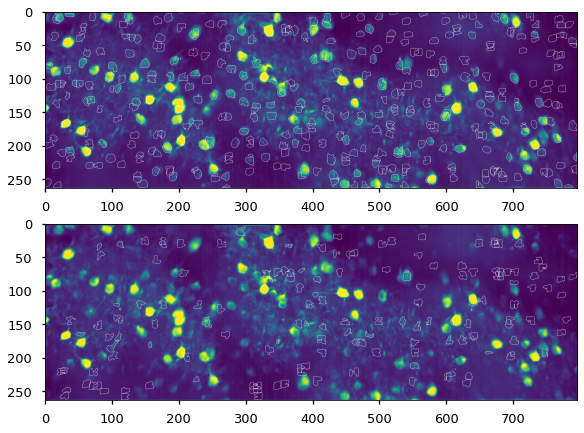

In [30]:
plt.subplot(2,1,1)
plot_contours(cnm.estimates.A[:, cnm2.estimates.idx_components], Cn, 
              thr=0.9, display_numbers=False, 
              contour_args={'linewidth': 0.5, 'alpha': 0.5});
plt.subplot(2,1,2)
plot_contours(cnm.estimates.A[:, cnm2.estimates.idx_components_bad], Cn, 
              thr=0.9, display_numbers=False, 
              contour_args={'linewidth': 0.5, 'alpha': 0.5});
plt.savefig('Cn_' + fnames.split('\\')[-1][:-4] + '.pdf', bbox_inches='tight')

In [31]:
#%% Extract DF/F values
cnm2.estimates.detrend_df_f(quantileMin=8, frames_window=250) # this step generates cnm2.F_dff
cnm2.estimates.F_dff.shape

(529, 80000)

## Closing, saving, and creating denoised version

In [32]:
cnm2.save(fnames[:-4] + '.hdf5')

cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
print(log_files)

   325481042 [utils.py:recursively_save_dict_contents_to_group():481] [13596] Key empty_merged is not saved.
   325481138 [utils.py:recursively_save_dict_contents_to_group():511] [13596] A is sparse ****
   325483016 [utils.py:recursively_save_dict_contents_to_group():471] [13596] g is an object type
   325483023 [utils.py:recursively_save_dict_contents_to_group():481] [13596] Key merged_ROIs is not saved.
   325483024 [utils.py:recursively_save_dict_contents_to_group():481] [13596] Key coordinates is not saved.
   325483497 [utils.py:recursively_save_dict_contents_to_group():481] [13596] Key groups is not saved.
   325483500 [utils.py:recursively_save_dict_contents_to_group():481] [13596] Key optional_outputs is not saved.
   325484106 [cluster.py:         stop_server():348] [13596] stop_cluster(): done


[]


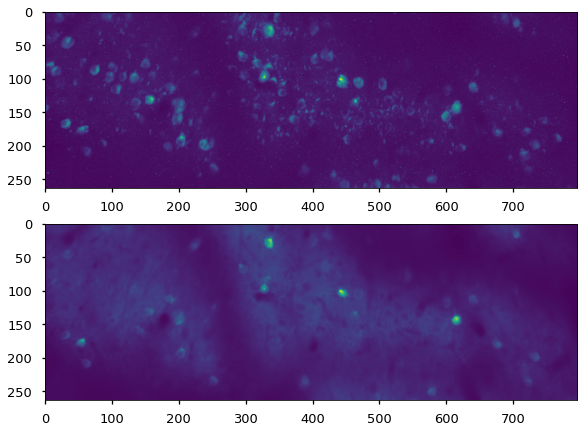

In [33]:
movie = cm.base.movies.movie(images,start_time=0,fr=30)
max_proj = np.max(movie, axis=0)
mean_img = np.mean(movie, axis=0)

plt.subplot(2, 1, 1)
plt.imshow(max_proj) # after registering
plt.subplot(2, 1, 2)
plt.imshow(mean_img)